# Hydrogel-Cell Interaction

In this case, we only have the deformed shape of the spherical hydrogel as shown in the next few cells.

In [14]:
import numpy as np
import scipy as sp
import scipy.sparse as spm
from scipy.io import loadmat, savemat

import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import sys, time, os.path
from itertools import permutations

module_path = '../module/'
sys.path.append(module_path)
from SHUtil import SphCoord_to_CartCoord, CartCoord_to_SphCoord

import pyshtools
from SHUtil import SHCilmToVector, SHVectorToCilm, lmk2K, K2lmk
from SHUtil import plotfv, TransMat, l_coeffs, m_coeffs, LM_list
from ShElastic import calSmode, calUmode
from SHBV import generate_submat, visualize_Cmat, print_SH_mode

from scipy.sparse.linalg import lsqr, spsolve
from scipy.interpolate import RectBivariateSpline
from scipy.optimize import minimize

from Case05_utilities import d2v, d2e, d2f
from Case05_utilities import Uvec2Tvec, Tvec2Uvec
from Case05_utilities import SHVec2mesh, visSHVec, visSH3d
from Case05_utilities import SHvec_rtoc, SHvec_ctor
from Case05_utilities import generate_fcache, generate_Xneigh, generate_Eneigh, generate_Fneigh

In [15]:
############################# change inputs here #################################
# Data file name
datadir = '../testdata'
smoothed = 'smoothed_lmax30_lwork25'; # smoothed = 'smoothed'; smoothed = '';
dilated = '_smoothed'; # dilated = '_1um_dilated'; # dilated = '';
shapename = 'Shape2'
datafile = os.path.join(datadir, shapename+'_Coordinates_Cart_'+smoothed+'.csv')
connfile = os.path.join(datadir, shapename+'_Connectivity.csv')
maskfile = os.path.join(datadir, shapename+'_Mask'+dilated+'.csv')

# Material properties
mu0 = 300/3;
mu = 1.; nu = 0.499;
# Spherical Harmonics Analysis Settings
lJmax = 30; lKmax = 30; lmax_plot = 60;
ldamp_lo = 10; ldamp_hi = 20; lwork = 9

# neibor list settings
n_list = 200
n_load = 10
n_recal_neigh = 1
file_neigh = shapename + '_neigh%d_lmax%d'%(n_list, lJmax) + smoothed + dilated

# regularizations
myalpha = 1e-3  # traction magnitude
mybeta  = 1e-4  # coefficient magnitude

# program switches
plot_figure = True
node_face_dist_on = None
opt_proc = [2, ]; myord = 1; # 2: sol2dr; myord: p-norm order
#opt_proc = [0, 1, 0, 1, 0, 1, 0, 1, 0]  # 1: node-face on; 0: node-face off;

# minimization settings
N_period = 500
maxiter_per_period = 5
CG_gtol = 1e-4
minimizer = 'CG'
minimizer_config = {'maxiter': maxiter_per_period, 'gtol': CG_gtol, 'disp': True}
# method='Powell', options={'maxiter':1, 'maxfev':10, 'disp': True})

# dump files for minimization
#AKinitfile = 'AK_iter_'+shapename+('_lmax%d'%20)+smoothed+dilated+'.npy'
AKinitfile = 'AK_iter_'+shapename+('_lmax%d'%20)+'_1um_dilated.npy'
savename = shapename+('_lmax%d'%lJmax)+smoothed+dilated
AKfile = 'AK_iter_'+savename+'.npy'
fvfile = 'fv_'+savename+'.txt'

# settings for loading \hat{U}, \hat{T} coefficients
shtype = 'reg'
coeff_dir = os.path.join(module_path, 'lmax%dmodes'%60)
#################################################################################

Umodes = loadmat(os.path.join(coeff_dir,'Umodes.mat'))
Umodes = (Umodes['U1'+shtype], Umodes['U0'+shtype])
fullDmat = calUmode(Umodes, mu, nu)
Dmat = generate_submat(mu, nu, fullDmat, lKmax, lJmax, kJ=3).tocsc()

Tmodes = loadmat(os.path.join(coeff_dir,'Tmodes.mat'))
Tmodes = (Tmodes['T1'+shtype], Tmodes['T2'+shtype], Tmodes['T3'+shtype], Tmodes['T0'+shtype])
fullCmat = calSmode(Tmodes, mu, nu)
Cmat = generate_submat(mu, nu, fullCmat, lKmax, lJmax, kJ=3).tocsc()

data, connectivity: (8136, 3) (16268, 3)
id of nodes, edges, facets: (8136,) (24402, 2) (16268, 3)
coord of nodes, edges, facets: (8136, 3) (24402, 2, 3) (16268, 3, 3)


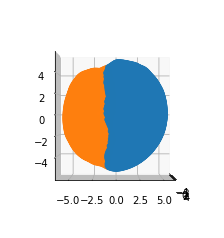

In [16]:
#### load the geometry ####
# Vs, Vp: list of nodes (nV, trivial), coordinates of the nodes (nVx3)
# Es, Ep: list of edges (nEx2), list of points on the edges (nEx2x3)
# Fs, Fp: list of facets (nFx3), list of points on the facets (nFx3x3)
# Tfv: traction free boundary map of the node list
# Tfe: traction free boundary map of the edge list
# Tff: traction free boundary map of the face list
# Tf_diluted: diluted traction free boundary map

data = np.genfromtxt(datafile, delimiter=',')
conn = np.genfromtxt(connfile, delimiter=',', dtype=np.int)
if dilated == '_smoothed':
    masktype = np.float
else:
    masktype = np.int
if shapename == 'Shape4':
    mask = np.zeros_like(data[:,0]).astype(masktype)
else:
    mask = np.genfromtxt(maskfile, dtype=masktype)
print('data, connectivity:', data.shape, conn.shape)

Fs = conn - 1
Np = data.shape[0]
Vs = np.arange(Np)
edge_conn = spm.lil_matrix((Np, Np), dtype=bool)
for i, j in permutations(range(3), 2):
    edge_conn[Fs[:, i], Fs[:, j]] = True
Es = spm.triu(edge_conn).tocoo()
Es = np.vstack([Es.row, Es.col]).T
print('id of nodes, edges, facets:', Vs.shape, Es.shape, Fs.shape)
Vp = data[..., :3]
Ep = Vp[Es, :]; Fp = Vp[Fs, :];
print('coord of nodes, edges, facets:', Vp.shape, Ep.shape, Fp.shape)

if dilated == '_smoothed':
    Tfv = (mask > 0.5)
else:
    Tfv = mask.astype(np.bool)
#Tfe = np.all(Tfv[Es], axis=1)
#Tff = np.all(Tfv[Fs], axis=1)
#print('Traction free boundary of v, e, f:', Tfv.shape, Tfe.shape, Tff.shape)

#### Plot the geometry (Vp) ####
if plot_figure:
    fig = plt.figure()#figsize=(16,16))
    ax = fig.add_subplot(111, projection='3d')

    nTfv = np.logical_not(Tfv)
    ax.scatter3D(Vp[Tfv, 0], Vp[Tfv, 1], Vp[Tfv, 2])
    ax.scatter3D(Vp[nTfv, 0], Vp[nTfv, 1], Vp[nTfv, 2])

    #eTf = Line3DCollection(np.hstack([Ep[Tfe, 0, :], Ep[Tfe, 1, :]]).copy().reshape((-1,2,3)), colors='C0')
    #ax.add_collection(eTf)
    #nTfe = np.logical_not(Tfe)
    #eTf = Line3DCollection(np.hstack([Ep[nTfe, 0, :], Ep[nTfe, 1, :]]).copy().reshape((-1,2,3)), colors='C1')
    #ax.add_collection(eTf)

    ax.view_init(azim=0, elev=0)

    ax.set_aspect('equal')
    plt.show()

Then we determine the original radius of the particle, assuming the particle is incompressible. The total volume can be estimated by adding the volume of the tetrahedrons. The volume of a tetrahedron is calculated as:

$$
V_{0123}=\frac{1}{6}
\begin{vmatrix}
 x_1 & y_1 & z_1 & 1\\ 
 x_2 & y_2 & z_2 & 1\\ 
 x_3 & y_3 & z_3 & 1\\ 
 0 & 0 & 0 & 1\\ 
\end{vmatrix}
$$

In [17]:
tet = np.zeros((Fs.shape[0], 4, 4))
tet[:,:-1,:-1] = Fp
tet[:,:,-1] = 1
vol = np.sum(np.linalg.det(tet)/6, axis=0)
r0 = np.cbrt(vol/(4/3*np.pi))
print('V = %.4f, r0 = %.4f'%(vol, r0))

V = 607.3027, r0 = 5.2534


We need to solve the reverse problem of a deformed shape. We will try the following methods to tackle this problem:

1. Assume $r$-direction deformation only, using the solution as initial guess to the optimization
2. LSQ solving coeffs of the SH solutions for fitting both the traction-free boundary and the shape

## 1. Obtain the initial guess

First thing to try is assuming that the deformation only happens on $r$-direction.

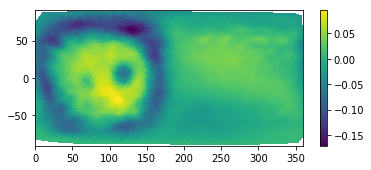

In [18]:
# Vp -> ur (radial displacement) -> u1 (x,y,z)
Vr, Vthe, Vphi = CartCoord_to_SphCoord(Vp[...,0], Vp[...,1], Vp[...,2])
Vphi[Vphi < 0] += 2*np.pi
Vlat = 90-np.rad2deg(Vthe)
Vlon = np.rad2deg(Vphi)

ur = (Vr - r0)/r0

# plot 2d map of the radial displacement
if plot_figure:
    pVlon = Vlon - 180
    pVlon[pVlon < 0] += 360
    plt.figure(figsize=(6,2.5))
    plt.tripcolor(pVlon, Vlat, ur)
    plt.colorbar()
    plt.axis('equal')
    plt.xlim(0, 360)
    plt.ylim(-90, 90)
    plt.show()

load AKinit from file: AK_iter_Shape2_lmax20_1um_dilated.npy
Coefficients of the Initial Guess in Solution Space...AK


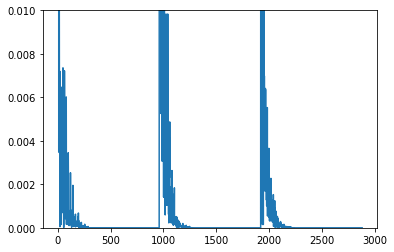

Displacement in Spherical Coordinates...


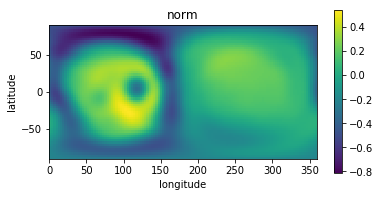

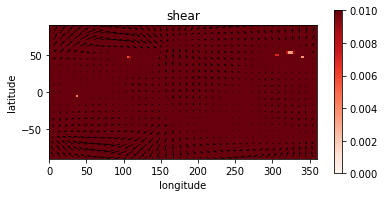

SH Coefficients of the Initial Guess Displacement...U1avec0


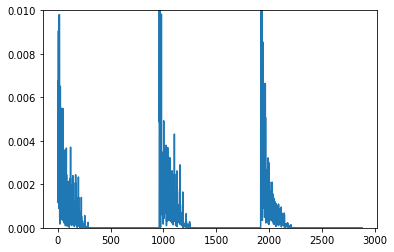

Time: 0.0481s
Traction in Spherical Coordinates...


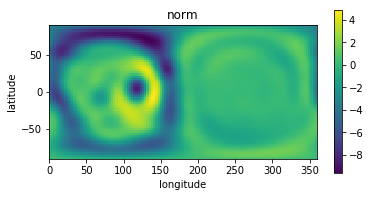

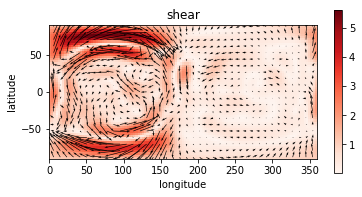

SH Coefficients of the Initial Guess Displacement...T1avec0


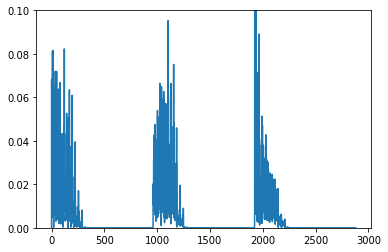

In [19]:
# Construct initial guess AK
if not os.path.exists(AKinitfile):
    print('Calculate AKinit from assumption of ur only...')
    # guess from radial displacement only
    urcilm, chi2 = pyshtools.expand.SHExpandLSQ(ur, Vlat, Vlon, lmax=lJmax)
    print(chi2)
    urcoeffs = pyshtools.SHCoeffs.from_array(urcilm)
    urcoeffs.info()
    spec_before = urcoeffs.spectrum(unit='per_lm')
    if plot_figure:
        fig, ax = urcoeffs.plot_spectrum(unit='per_lm')
    # damp the high order coefficients
    # ldamp = sp.special.erfc((l_coeffs(lJmax) - lmax_mean)/(lmax_buf/4))/2
    # urcoeffs = pyshtools.SHCoeffs.from_array(urcilm)
    # spec_after = urcoeffs.spectrum(unit='per_lm')
    #if plot_figure:
    #    plt.figure(figsize=(10,4))
    #    plt.subplot(121)
    #    plt.plot(ldamp[0,:,0])
    #    plt.subplot(122)
    #    plt.semilogy(spec_before); plt.semilogy(spec_after);
    #    plt.legend(['before damping', 'after damping'])
    #    plt.show()
    # visualize ur map
    urgrid = urcoeffs.pad(lmax=lmax_plot).expand('GLQ')
    if plot_figure:
        urgrid.info()
        urgrid_plot = urgrid.copy()
        urgrid_plot.data = np.roll(urgrid.data, lmax_plot+1, axis=1)
        fig, ax = urgrid_plot.plot()
    # Convert Back to ux,uy,uz on regular mesh
    Q = TransMat(lJmax=urgrid.lmax)
    print('Size of transfer matrix:', Q.shape)
    u1a = urgrid.data[:,:,np.newaxis]*Q[:, :, 0, :]
    print('Size of Cartesian representation of displacement:', u1a.shape)
    # decompose the displacement field into spherical harmonic coefficients
    U1avec0 = [None for _ in range(3)]
    for k in range(3):
        u1agrid = pyshtools.SHGrid.from_array(u1a[...,k].astype(np.complex), grid='GLQ')
        u1acoeffs = u1agrid.expand().pad(lmax=lJmax)
        U1avec0[k] = SHCilmToVector(u1acoeffs.to_array())
    U1avec0 = np.hstack(U1avec0)
    lv, _ = LM_list(lJmax); lv_ones = np.ones_like(lv);
    lv_lim = np.minimum(np.maximum(lv, ldamp_lo), ldamp_hi)
    ldamp = np.sin(np.pi/2*(ldamp_hi-lv_lim)/(ldamp_hi-ldamp_lo))**2
    AKdamp = np.tile(ldamp, 3)
    AK_init = spsolve(Dmat, U1avec0.T)*AKdamp
    if plot_figure:
        plt.semilogy(np.abs(spsolve(Dmat, U1avec0.T)));
        plt.semilogy(np.abs(AK_init)); plt.show();

else: # load the initial guess from a file
    print('load AKinit from file:', AKinitfile)
    AK_tmp = np.load(AKinitfile).reshape(3, -1)
    AK_init = np.zeros((3, (lJmax+1)**2), dtype=np.complex)
    lJmax_init = np.int(np.sqrt(AK_tmp.shape[1]) - 1)
    # padding
    if lJmax_init > lJmax:
        AK_init = AK_tmp[:, :((lJmax+1)**2)]
    else:
        AK_init[:, :((lJmax_init+1)**2)] = AK_tmp
    AK_init = AK_init.flatten()
    #U1avec0 = Dmat.dot(AK_init)
    lv, _ = LM_list(lJmax); lv_ones = np.ones_like(lv);
    lv_lim = np.minimum(np.maximum(lv, ldamp_lo), ldamp_hi)
    ldamp = (ldamp_hi-lv_lim)/(ldamp_hi-ldamp_lo) #np.sin(np.pi/2*(ldamp_hi-lv_lim)/(ldamp_hi-ldamp_lo))**2
    U1damp = np.tile(ldamp, 3)**4
    U1avec0 = Dmat.dot(AK_init)*U1damp
    AK_init = spsolve(Dmat, U1avec0.T)

if plot_figure:
    print('Coefficients of the Initial Guess in Solution Space...AK')
    plt.plot(np.abs(AK_init))
    plt.ylim(0,0.01)
    plt.show()
    print('Displacement in Spherical Coordinates...')
    fig, ax = visSHVec(U1avec0*r0, lmax_plot=lmax_plot, SphCoord=True, Complex=True, s_vrange=(0,0.01),
                           config_quiver=(2, 3, 'k', 20), lonshift=180, figsize=(6,3))
    print('SH Coefficients of the Initial Guess Displacement...U1avec0')
    plt.plot(np.abs(U1avec0))
    plt.ylim(0,0.01)
    plt.show()
    T1avec0 = Uvec2Tvec(U1avec0, Cmat, Dmat)
    print('Traction in Spherical Coordinates...')
    fig, ax = visSHVec(T1avec0*r0, lmax_plot=lmax_plot, SphCoord=True, Complex=True,
                           config_quiver=(2, 3, 'k', 40), lonshift=180, figsize=(6,3))
    print('SH Coefficients of the Initial Guess Displacement...T1avec0')
    plt.plot(np.abs(T1avec0))
    plt.ylim(0,0.1)
    plt.show()

## 2. LSQ solving SH coeffs for displacement field

Obviously, the decomposition is not satisfactory. It is not reasonable to assume the deformation is only on $r$-direction. In this section, we will try to optimize SH coeffs, so that the deformed shape is closest to the data. Notice that the integral of a spherical harmonic function on the sphere surface is:

$$
\int_0^{2\pi}\!\int_0^{\pi}Y_l^m(\theta,\varphi)\sin\theta d\theta d\varphi = 4\pi\delta_{l0}\delta_{m0}
$$

Therefore, only the $Y_0^0$ term controls the rigid body translation (constant). If we only impose higher mode spherical harmonics, there will be no rigid body motion.

### 2.1 Developing shape-difference function and neighbor list

We first develop the distance function of the point sets to the surface. The distance of a point $x$ to the surface is defined as: $d(x) = \min[d_{v}(x), d_{e}(x), d_{f}(x)]$, where $d_v(x)$, $d_e(x)$, $d_f(x)$ are the closest distances of $x$ to the vertices, edges, and faces respectively.

* For a vertex $v=(v_1,v_2,v_3)^T$, $d_v(x)=\|\mathbf{x-v}\|_2$. The test script is attached.

* For an edge $e=(r_1, r_2)$, the projection point $\vec{r_1q}$ on $\vec{r_1r_2}$ is 
$$
\vec{r_1q} = \frac{\vec{r_1x}\cdot\vec{r_1r_2}}{\|\vec{r_1r_2}\|}\,\frac{\vec{r_1r_2}}{\|\vec{r_1r_2}\|}
$$

The projection is in the interval $r_1r_2$ if $t=\|\vec{r_1q}\|/\|\vec{r_1r_2}\|\in(0,1)$. 
Thus, the distance to the edge is calculated as:
$$
d_e(x)=
\begin{cases}
\|\vec{r_1x}\|,\; t\le0 \\
\|\vec{qx}\|,\; 0<t\le1 \\
\|\vec{r_2x}\|,\; t>1 
\end{cases}
$$
A test case is attached here.

* For a face $f=(r_1, r_2, r_3)$, the normal vector:
$$
n = \frac{\vec{r_1r_2}\times\vec{r_1r_3}}{\|\vec{r_1r_2}\times\vec{r_1r_3}\|}
$$
Then the distance can be calculated as:
$$
d_f(x)=\|\vec{r_1x}\cdot\vec{n}\|
$$
if the projection point $q$ is in the triangle, where $q = x - (\vec{r_1x}\cdot\vec{n})\vec{n}$.

To test this, we calculate the barycentric coordinates of $q$:
$$
b_3 = \frac{\|r_1\|^2\times(\vec{r_1r_3}\cdot\vec{r_1q})-
            (\vec{r_1r_2}\cdot\vec{r_1r_3})\times(\vec{r_1r_2}\cdot\vec{r_1q})}
           {\|r_1\|^2\|r_2\|^2-(\vec{r_1r_2}\cdot\vec{r_1r_3})^2}\\
b_2 = \frac{\|r_2\|^2\times(\vec{r_1r_2}\cdot\vec{r_1q})-
            (\vec{r_1r_2}\cdot\vec{r_1r_3})\times(\vec{r_1r_3}\cdot\vec{r_1q})}
           {\|r_1\|^2\|r_2\|^2-(\vec{r_1r_2}\cdot\vec{r_1r_3})^2}\\
b_1 = 1 - b_2 - b_3
$$

If any $b_i < 0$, $q$ is outside of the triangle, we then calculate the point edge distances $d_e(x)$ instead.

With the distance function ready, we can develop the neighbor list by choosing the closest `n_list` vertices, edges and faces to the points:

In [20]:
# Shape of the initial guess U1avec0: Xt = X0 + u1a
latsdeg, lonsdeg = pyshtools.expand.GLQGridCoord(lJmax)
lon = np.deg2rad(lonsdeg)
colat = np.deg2rad(90-latsdeg)
PHI, THETA = np.meshgrid(lon, colat)
R = np.ones_like(PHI)
X,Y,Z = SphCoord_to_CartCoord(R, THETA, PHI)
X0 = np.stack([X,Y,Z], axis=-1)

Xt = X0 + SHVec2mesh(U1avec0, lmax=lJmax, SphCoord=False, Complex=True)

Calculate and visualize the neighbor list on deformed shape:

In [21]:
if (node_face_dist_on is not None) or (0 in opt_proc) or (1 in opt_proc):
    if not os.path.exists(file_neigh+'.npz'):
        #Xneigh, Eneigh, Fneigh = generate_neighbor_list(Xt, Xref=Vp/r0, Eref=Ep/r0, Fref=Fp/r0, filename=file_neigh, n_list=n_list)
        Xneigh = generate_Xneigh(Xt, Vp/r0, n_list=n_list, filename=file_neigh)
        Eneigh = generate_Eneigh(Xt, Ep/r0, n_list=n_list, filename=file_neigh)
        Fneigh = generate_Fneigh(Xt, Fp/r0, n_list=n_list, filename=file_neigh)
        np.savez(file_neigh, Xneigh=Xneigh, Eneigh=Eneigh, Fneigh=Fneigh)

    Xneigh = np.load(file_neigh+'.npz')['Xneigh'][...,:n_load,:]
    Eneigh = np.load(file_neigh+'.npz')['Eneigh'][...,:n_load,:,:]
    Fneigh = np.load(file_neigh+'.npz')['Fneigh'][...,:n_load,:,:]
    print('Neighbor list:', Xneigh.shape, Eneigh.shape, Fneigh.shape)

    if plot_figure:
        i = np.int(lJmax/4); j = np.int(3*lJmax/2)+1; k = np.int(lJmax/2)
        fig = plt.figure(figsize=(12,8))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter3D(Xt[0:k,:, 0], Xt[0:k,:, 1], Xt[0:k,:, 2])
        ax.scatter3D(Xt[i, j, 0], Xt[i, j, 1], Xt[i, j, 2], s=200)
        ax.scatter3D(Xneigh[i, j, :, 0], Xneigh[i, j, :, 1], Xneigh[i, j, :, 2], marker = '^')
        ax.view_init(azim=-90, elev=0)
        ax.set_zlim3d(0, 1); ax.set_xlim3d(-0.5, 0.5); ax.set_ylim3d(-1, 0)
        plt.show()

### Develop the interpolation function for $r(\theta,\varphi)$ from data

2.0951485691564662e-09


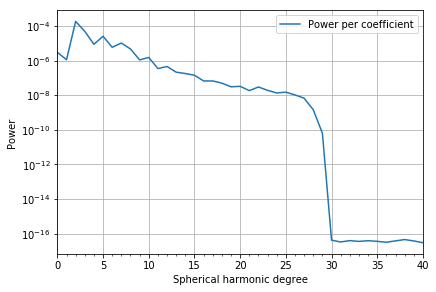

kind = 'real'
grid = 'GLQ'
nlat = 41
nlon = 81
lmax = 40
(43, 82) (43, 82) (43, 82)
(43,) (82,)
(3526,)
(8136,) 0.0011470317840576172
[-0.00087749 -0.00063522 -0.00034814 ... -0.00016751 -0.00017508
 -0.00024677]


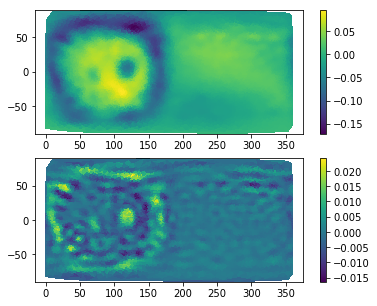

In [22]:
if (2 in opt_proc):
    urcilm_interp, chi2 = pyshtools.expand.SHExpandLSQ(ur, Vlat, Vlon, lmax=lJmax+10)
    print(chi2)

    ucoeff_interp = pyshtools.SHCoeffs.from_array(urcilm_interp)
    urgrid_interp = ucoeff_interp.expand('GLQ')

    if plot_figure:
        fig, ax = ucoeff_interp.plot_spectrum(unit='per_lm')
        urgrid_interp.info()

    from scipy.interpolate import RectBivariateSpline

    lats = urgrid_interp.lats(); lons = urgrid_interp.lons()
    lats_circular = np.hstack(([90.], lats, [-90.]))
    lons_circular = np.append(lons, 360)
    LONS, LATS = np.meshgrid(lons_circular, lats_circular)
    xmesh = urgrid_interp.to_array().copy()
    fpoints = np.zeros_like(LONS)
    fpoints[1:-1, :-1] = xmesh
    fpoints[0, :] = np.mean(xmesh[0,:], axis=0)  # not exact !
    fpoints[-1, :] = np.mean(xmesh[-1,:], axis=0)  # not exact !
    fpoints[1:-1, -1] = xmesh[:, 0]
    print(LATS.shape, LONS.shape, fpoints.shape)
    print(lats_circular.shape, lons_circular.shape)
    f_interp = RectBivariateSpline(lats_circular[::-1], lons_circular, fpoints[::-1, ], kx=1, ky=1)

    ## Test the interpolation algorithm

    tic = time.time()
    ur_interp = f_interp.ev(Vlat, Vlon)
    toc = time.time()
    print(f_interp.get_coeffs().shape)
    print(ur_interp.shape, toc-tic)
    print(ur_interp - ur)

    if plot_figure:
        plt.figure(figsize=(6,5))
        plt.subplot(211)
        plt.tripcolor(pVlon, Vlat, ur)
        plt.colorbar()
        plt.axis('equal')
        plt.xlim(0, 360)
        plt.ylim(-90, 90)
        plt.subplot(212)
        plt.tripcolor(pVlon, Vlat, (ur_interp-ur)*r0)
        plt.colorbar()
        plt.axis('equal')
        plt.xlim(0, 360)
        plt.ylim(-90, 90)
        plt.show()

### 2.2  From `uvec` to the shape difference

After we obtain the neighbor list, the shape can be obtained from the real SH vector `uvec`. This can be used for the optimization of the shape.

In [23]:
from Case05_utilities import coeffs2dr, coeffs2dist
# detailed implementation in Case05_utilities.py

lat_weights = np.sin(THETA)
vert_weight = np.array([1,1,1./3])
l_list, m_list = LM_list(lJmax)

### 2.3 Target function including shape and traction

A_weight.shape = (2883,)


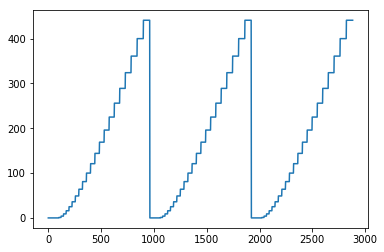

In [24]:
# Define weights and traction free region
x0 = Xt;
dist2mat = np.linalg.norm(x0[..., np.newaxis, :] - Vp/r0, axis=-1)
arg_list_x = dist2mat.argmin(axis=-1)
if dilated == '_smoothed':
    isTfv = mask[arg_list_x]
else:
    isTfv = Tfv[arg_list_x]

Q = TransMat(lJmax=lJmax)           # transformation matrix from Cartesian to Spherical Coordinates
l_list, m_list = LM_list(lJmax)
#ndamp = ((lJmax+1)**2 - (lJmax+1-lmax_buf)**2)*3
l_weight = l_list - lwork; l_weight[l_weight < 0] = 0; l_weight = l_weight**2; #(np.exp(l_weight) - 1);
A_weight = np.tile(l_weight, 3)

print("A_weight.shape =",A_weight.shape)
if plot_figure:
    plt.plot(A_weight); 
    plt.show()

In [25]:
from Case05_utilities import sol2dr, sol2dist, sol2dist_verbose, sol2dist_update

We use the solution we obtained from Section 1 `Uvec_real` for the testing:

Calculate node-node distances without and with weights...
minimum distances squared from all mesh points:
[1.12338452e-04 5.57998300e-04 1.03444272e-03 6.64535252e-04
 5.80183874e-04 3.85755334e-04 8.36899994e-05 1.65129798e-05
 2.11520275e-05 5.63423839e-05 5.56391075e-05 4.05398369e-05
 9.35731672e-05 1.33508069e-04 9.93381774e-05 1.12552031e-04
 1.51215269e-04 1.11818322e-04 1.00773049e-04 1.99375705e-04
 2.75615710e-04 2.70527102e-04 3.56593447e-04 3.68121243e-04
 3.53281739e-04 4.67738956e-04 8.02100134e-04 1.36734555e-03
 1.51688903e-03 1.44395480e-03 1.33379802e-03]
mean of minimum distances squared: 0.00020550539588883685


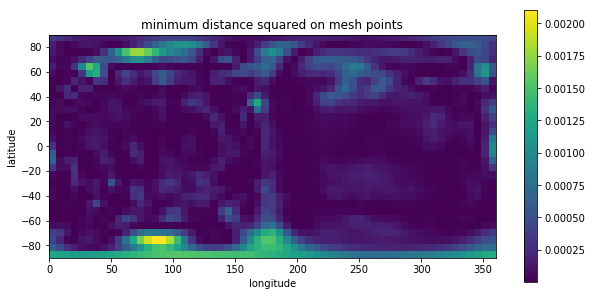

mean of minimum distances 2 -norm: 0.00020550539588883683
compare only neighbor list: dist = 0.00020551, time = 0.0039
Calculate target function using alpha= 0 beta = 0
compare only neighbor list: dist = 0.00040674, time = 0.0125
Calculate target function using alpha= 0.001 beta = 0.0001
compare only neighbor list: dist = 0.00029887, time = 0.0122
  mean shape difference = 0.0753um
  mean |T| in free surface = 27.0630Pa
  regularization = 2.917489e-03pJ


In [26]:
print('Calculate node-node distances without and with weights...')

tic = time.time()
dist_test = coeffs2dr(U1avec0, f_interp=f_interp, lmax=lJmax, X0=X0, Complex=True, debug=True)
toc = time.time()
print("minimum distances squared from all mesh points:")
norm2 = np.sum(dist_test**2, axis=-1)
print(norm2[:,0])
print("mean of minimum distances squared:", norm2.mean())
if plot_figure:
    fig, ax = plotfv(norm2, show=False, lonshift=180)
    ax.set_title('minimum distance squared on mesh points')
    plt.show()
print("mean of minimum distances",myord*2,"-norm:", np.linalg.norm(norm2.flatten(), ord=myord)/(lJmax+1)/(2*lJmax+1))

tic = time.time()
dist_test = coeffs2dr(U1avec0, f_interp=f_interp, lmax=lJmax, X0=X0, Complex=True, norm_order=myord)
toc = time.time()
print('compare only neighbor list: dist = %.8f, time = %.4f'%(dist_test, toc-tic))

print('Calculate target function using alpha=',0,'beta =',0)
tic = time.time()
dist_test = sol2dr(AK_init, Cmat, Dmat, alpha = 0, beta = 0.001, isTfv=isTfv, f_interp=f_interp, separate=False, lmax=lJmax, X0=X0, l_weight=A_weight, norm_order=myord)
toc = time.time()
print('compare only neighbor list: dist = %.8f, time = %.4f'%(dist_test, toc-tic))

print('Calculate target function using alpha=',myalpha,'beta =',mybeta)
tic = time.time()
dist_test = sol2dr(AK_init, Cmat, Dmat, alpha = myalpha, beta = mybeta, isTfv=isTfv, f_interp=f_interp, separate=False, lmax=lJmax, X0=X0, l_weight=A_weight, norm_order=myord)
toc = time.time()
print('compare only neighbor list: dist = %.8f, time = %.4f'%(dist_test, toc-tic))
dist_test = sol2dr(AK_init, Cmat, Dmat, alpha = myalpha, beta = mybeta, isTfv=isTfv, f_interp=f_interp, separate=True, lmax=lJmax, X0=X0, l_weight=A_weight, norm_order=myord)
verb = sol2dist_verbose(dist_test, mu0=mu0, r0=r0)

### 2.4 Solution by minimizing the target function

Then we can optimizing the solution by minimizing the distance:

In [ ]:
from Case05_utilities import minimize_AK

### 2.5 The optimization process, use node-node and node-face interchangably

In [ ]:
if (node_face_dist_on is not None) or (0 in opt_proc) or (1 in opt_proc):
    args_node_node = (Cmat, Dmat, myalpha, mybeta, isTfv, None, lJmax, X0, Xneigh,
                      lat_weights, vert_weight, A_weight)
    args_node_face = (Cmat, Dmat, myalpha, mybeta, isTfv, f_cached, lJmax, X0, Fneigh, 
                      lat_weights, vert_weight, A_weight)
    iter_config_sol2dist = {'N_period': N_period, 'minimizer': minimizer, 'minimizer_config': minimizer_config,
                        'n_update': n_recal_neigh, 'update': sol2dist_update}
if (2 in opt_proc):
    args_dr = (Cmat, Dmat, myalpha, mybeta, isTfv, f_interp, lJmax, X0, 
               lat_weights, vert_weight, A_weight, myord)
    iter_config_sol2dr = {'N_period': N_period, 'minimizer': minimizer, 'minimizer_config': minimizer_config,
                          'n_update': 0}

AK_iter = AK_init
for i_proc in opt_proc:
    if i_proc == 1:
        target = sol2dist; iter_config = iter_config_sol2dist; args = args_node_face
    elif i_proc == 0:
        target = sol2dist; iter_config = iter_config_sol2dist; args = args_node_node
    else:
        target = sol2dr; args = args_dr; iter_config = iter_config_sol2dr
    AK_iter, funval = minimize_AK(AK_iter, target, args, iter_config, verbose_args=(r0, mu0),
                                  verbose=sol2dist_verbose, AKfile=AKfile, fvfile=fvfile, file_neigh=file_neigh)
AK_final = AK_iter

In [ ]:
# To do:
# 1. Save solution: AK_iter (overwrite), funval (append) to file every step (done)
# 2. Every run has its own folder (done)
# 3. add option for node-face distance in optimization (done)
# 4. wrap the minimization into function (done)
# 5. spherical harmonics shape-difference representation
#    5.1. interpolation from irregular ur data (done)
#    5.2. new coeffs2dist (done)
# 6. smoothed edge of traction free boundary
#    6.1. smooth the edge (Case05-Hydrogel_Cell_Interaction-smoothed_mask.ipynb) (done)
#    6.2. optimize with smoothed edge (done)

# Uncomment the following line if want to save AKfile from memory
# np.save(AKfile, AK_min.x)
# plt.plot(AK_min.x); plt.show()
# Uncomment the following line if want to save fvfile from memory
# np.savetxt(fvfile, np.hstack([np.arange(plot_funval.shape[0]).reshape(-1,1), plot_funval]), fmt='%8d %e %e %e')

In [ ]:
# Plot saved minimization progress data
if plot_figure:
    #funval = np.loadtxt(fvfile)[:, 1:]
    plot_funval = np.array(funval)
    plt.figure(figsize=(14,5))
    plt.subplot(131)
    plt.plot(plot_funval[:, 0])
    plt.subplot(132)
    plt.plot(plot_funval[:, 1])
    plt.subplot(133)
    plt.plot(plot_funval[:, 2])
    plt.show()

# Note that `umesh` and `tmesh` here are normalized on the unit sphere

In [ ]:
if plot_figure:
    Uvec1 = Dmat.dot(AK_final); Tvec1 = Uvec2Tvec(Uvec1, Cmat, Dmat)
    print('Displacement and Traction in Cartesian Coordinates...')
    umesh1 = SHVec2mesh(Uvec1, lmax=lJmax, SphCoord=False, Complex=True)
    tmesh1 = SHVec2mesh(Tvec1*mu0, lmax=lJmax, SphCoord=False, Complex=True)
    umesh1_fine = SHVec2mesh(Uvec1, lmax=lmax_plot, SphCoord=False, Complex=True)
    tmesh1_fine = SHVec2mesh(Tvec1*mu0, lmax=lmax_plot, SphCoord=False, Complex=True)
    print('Visualize the nodes in 3D...')
    fig, ax = visSH3d(umesh1, cmesh=tmesh1, r0=r0, show=False, elevation=0, azimuth=0, surface=False, figsize=(4,4))
    nTfv = np.logical_not(Tfv)
    ax.scatter3D(Vp[Tfv, 0], Vp[Tfv, 1], Vp[Tfv, 2], marker='^', s=10)
    ax.scatter3D(Vp[nTfv, 0], Vp[nTfv, 1], Vp[nTfv, 2], marker='^', s=10)
    plt.show()
    print('Visualize the shape in 3D...')
    fig, ax = visSH3d(umesh1_fine, cmesh=tmesh1_fine, r0=r0, show=False, elevation=0, azimuth=0, surface=True, figsize=(4,4))
    nTfv = np.logical_not(Tfv)
    ax.scatter3D(Vp[Tfv, 0], Vp[Tfv, 1], Vp[Tfv, 2], marker='^', s=10)
    ax.scatter3D(Vp[nTfv, 0], Vp[nTfv, 1], Vp[nTfv, 2], marker='^', s=10)
    plt.show()
    fig, ax = visSH3d(umesh1_fine, cmesh=tmesh1_fine, r0=r0, show=False, elevation=0, azimuth=-90, surface=True, figsize=(4,4))
    nTfv = np.logical_not(Tfv)
    ax.scatter3D(Vp[Tfv, 0], Vp[Tfv, 1], Vp[Tfv, 2], marker='^', s=10)
    ax.scatter3D(Vp[nTfv, 0], Vp[nTfv, 1], Vp[nTfv, 2], marker='^', s=10)
    plt.show()
    fig, ax = visSH3d(umesh1_fine, cmesh=tmesh1_fine, r0=r0, show=False, elevation=90, azimuth=0, surface=True, figsize=(4,4))
    nTfv = np.logical_not(Tfv)
    ax.scatter3D(Vp[Tfv, 0], Vp[Tfv, 1], Vp[Tfv, 2], marker='^', s=10)
    ax.scatter3D(Vp[nTfv, 0], Vp[nTfv, 1], Vp[nTfv, 2], marker='^', s=10)
    plt.show()

In [ ]:
# Test objection functions
if (node_face_dist_on is not None) or (0 in opt_proc) or (1 in opt_proc):
    i = 5; j = 31; k = 10

    if plot_figure:
        fig = plt.figure(figsize=(12,6))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter3D(Xt[i, j, 0], Xt[i, j, 1], Xt[i, j, 2], s=200)
        ax.scatter3D(Xneigh[i, j, :, 0], Xneigh[i, j, :, 1], Xneigh[i, j, :, 2], marker = '^')
        ax.view_init(azim=-90, elev=90)
        ax.set_zlim3d(0, 1); ax.set_xlim3d(-0.5, 0.5); ax.set_ylim3d(-1, 0)

    Xs = Xt[i,j,:]
    Xf = Fneigh[i,j,...]

    d2vmat = d2v(Xs, Xneigh[i,j,...], avg_dist=False)
    print('node-node distances:', np.sort(d2vmat)**2)

    Xv = Xf.reshape(-1, 3)
    Xe = np.vstack([np.stack([Xf[0,:,:], np.roll(Xf[0,:,:], 1, axis=0)], axis=1),
                    np.stack([Xf[1,:,:], np.roll(Xf[1,:,:], 1, axis=0)], axis=1)])
    tic = time.time()
    d2fmat, q = d2f(Xs, Xf, avg_dist=False, debug=True);
    toc = time.time()


    q = np.squeeze(q)
    d2e1, q1, _, _ = d2e(Xs, np.stack([Xf[0,:,:], np.roll(Xf[0,:,:], 1, axis=0)], axis=1), avg_dist=False, debug=True)
    d2e2, q2, _, _ = d2e(Xs, np.stack([Xf[1,:,:], np.roll(Xf[1,:,:], 1, axis=0)], axis=1), avg_dist=False, debug=True)
    q1 = q1.squeeze(); q2 = q2.squeeze();

    if plot_figure:
        fig = plt.figure(figsize=(12,6))
        ax = fig.add_subplot(111, projection='3d')

        ax.scatter3D(Xs[..., 0], Xs[..., 1], Xs[..., 2], 'C1',s=400) # nodepoint
        ax.scatter3D(Xv[..., 0], Xv[..., 1], Xv[..., 2], 'C0')       # neighbor list
        ax.scatter3D(q[..., 0], q[..., 1], q[..., 2], 'C2')          # projection point

    f_cached = generate_fcache(Xf)
    tic = time.time(); d2fmat = d2f(Xs, Xf, f_cached=f_cached); toc = time.time()
    print('total distance with cache:', d2fmat, toc-tic, 's')

    if plot_figure:
        edges = Line3DCollection(np.hstack([Xe[:,0,:], Xe[:,1,:]]).reshape((-1,2,3)), colors='C0')
        ax.add_collection(edges)
        #lines_3d = Line3DCollection(np.hstack([np.broadcast_to(Xs, Xv.shape), Xv]).reshape((-1,2,3)), colors='C1')
        #ax.add_collection(lines_3d)
        projection = Line3DCollection(np.hstack([np.broadcast_to(Xs, q.shape), q]).reshape((-1,2,3)), colors='C2')
        ax.add_collection(projection)
        projection1 = Line3DCollection(np.hstack([np.broadcast_to(Xs, q1.shape), q1]).reshape((-1,2,3)), colors='C3')
        ax.add_collection(projection1)
        projection2 = Line3DCollection(np.hstack([np.broadcast_to(Xs, q2.shape), q2]).reshape((-1,2,3)), colors='C3')
        ax.add_collection(projection2)
        ax.view_init(azim=-90, elev=90)
        #ax.set_aspect('equal')
        plt.show()

In [ ]:
if (node_face_dist_on is not None) or (0 in opt_proc) or (1 in opt_proc):
    print('Calculate node-node distances without and with weights...')

    tic = time.time()
    dist_test = coeffs2dist(U1avec0, Xneigh, lmax=lJmax, X0=X0, Complex=True,debug=True)
    toc = time.time()
    print("minimum distances squared from all mesh points:")
    print(dist_test.min(axis=-1)[:,0])
    print("mean of minimum distances squared:", dist_test.min(axis=-1).mean())
    #print('compare only neighbor list: dist = %.8f, time = %.4f'%(dist_test, toc-tic))
    if plot_figure:
        fig, ax = plotfv(dist_test.min(axis=-1), show=False, lonshift=180)
        ax.set_title('minimum distance squared on mesh points')
        plt.show()

    tic = time.time()
    dist_test = coeffs2dist(U1avec0, Xneigh, lmax=lJmax, X0=X0, Complex=True)
    toc = time.time()
    print('compare only neighbor list: dist = %.8f, time = %.4f'%(dist_test, toc-tic))

    print('Calculate target function using alpha=',0,'beta =',0)
    tic = time.time()
    dist_test = sol2dist(AK_init, Cmat, Dmat, alpha = 0, beta = 0, separate=False, Xt=Xneigh, lmax=lJmax, X0=X0, l_weight=A_weight)
    toc = time.time()
    print('compare only neighbor list: dist = %.8f, time = %.4f'%(dist_test, toc-tic))

    print('Calculate target function using alpha=',myalpha,'beta =',mybeta)
    tic = time.time()
    dist_test = sol2dist(AK_init, Cmat, Dmat, alpha = myalpha, beta = mybeta, separate=False, Xt=Xneigh, lmax=lJmax, X0=X0, l_weight=A_weight)
    toc = time.time()
    print('compare only neighbor list: dist = %.8f, time = %.4f'%(dist_test, toc-tic))

In [ ]:
if (node_face_dist_on is not None) or (0 in opt_proc) or (1 in opt_proc):
    print('Calculate node-face distances without weighing...')

    f_cached = generate_fcache(Fneigh)
    tic = time.time()
    dist_test = coeffs2dist(U1avec0, Fneigh, f_cached=f_cached, lmax=lJmax, X0=X0, Complex=True, debug=True)
    toc = time.time()
    print("minimum distances  squared from all mesh points:")
    print(dist_test.min(axis=-1)[:,0])
    print("mean of minimum distances squared: ",dist_test.min(axis=-1).mean())
    #print('compare only neighbor list: dist = %.8f, time = %.4f'%(dist_test, toc-tic))

    if plot_figure:
        fig, ax = plotfv(dist_test.min(axis=-1), show=False)
        ax.set_title('minimum distance squared on mesh points')
        plt.show()

    f_cached = generate_fcache(Fneigh)
    tic = time.time()
    dist_test = coeffs2dist(U1avec0, Fneigh, f_cached=f_cached, lmax=lJmax, X0=X0, Complex=True)
    toc = time.time()
    print('compare only neighbor list: dist = %.8f, time = %.4f'%(dist_test, toc-tic))

    print('Calculate target function using alpha =',0,'beta =',0)
    tic = time.time()
    dist_test = sol2dist(AK_init, Cmat, Dmat, alpha=0, beta=0, Xt=Fneigh, f_cached=f_cached, lmax=lJmax, X0=X0, l_weight=A_weight)
    toc = time.time()
    print('weighted distance: dist = %.8f, time = %.4f'%(dist_test, toc-tic))

    print('Calculate target function using alpha =',myalpha,'beta =',mybeta)
    tic = time.time()
    dist_test = sol2dist(AK_init, Cmat, Dmat, alpha=myalpha, beta=mybeta, Xt=Fneigh, f_cached=f_cached, lmax=lJmax, X0=X0, l_weight=A_weight)
    toc = time.time()
    print('weighted distance: dist = %.8f, time = %.4f'%(dist_test, toc-tic))

In [ ]:
if node_face_dist_on is not None:
    if not node_face_dist_on:
        AK_iter, funval = minimize_AK(AK_init, sol2dist, 
                              (Cmat, Dmat, myalpha, mybeta, None, lJmax, X0, Xneigh, 
                               lat_weights, vert_weight, A_weight),
                              {'N_period': N_period, 'minimizer': minimizer, 'minimizer_config': minimizer_config,
                               'n_update': n_recal_neigh, 'update': sol2dist_update}, 
                              verbose=sol2dist_verbose, AKfile='', fvfile='')
    else:
        AK_iter, funval = minimize_AK(AK_init, sol2dist, 
                              (Cmat, Dmat, myalpha, mybeta, f_cached, lJmax, X0, Fneigh, 
                               lat_weights, vert_weight, A_weight),
                              {'N_period': N_period, 'minimizer': minimizer, 'minimizer_config': minimizer_config,
                               'n_update': n_recal_neigh, 'update': sol2dist_update}, 
                              verbose=sol2dist_verbose, AKfile='', fvfile='')

### NOTE: All the displacements are normalized with $r_0$, and tractions are normalized with $\mu_0$

We expand $u_r$ and obtain regular-mesh representation, then obtain $u_x,u_y,u_z$ from $u_r$ on regular mesh ($u_\theta=u_\varphi=0$).